# **Dataset Generation**

In [1]:
import cv2
import os
import numpy as np
import random
import pickle

train_size = 9800
test_size = 200
img_size = 75
size = 5
question_size = 11 ##6 for one-hot vector of color, 2 for question type, 3 for question subtype
"""Answer : [yes, no, rectangle, circle, r, g, b, o, k, y]"""

nb_questions = 10
dirs = './data'

colors = [
    (0,0,255),##r
    (0,255,0),##g
    (255,0,0),##b
    (0,156,255),##o
    (128,128,128),##k
    (0,255,255)##y
]


try:
    os.makedirs(dirs)
except:
    print('directory {} already exists'.format(dirs))

def center_generate(objects):
    while True:
        pas = True
        center = np.random.randint(0+size, img_size - size, 2)        
        if len(objects) > 0:
            for name,c,shape in objects:
                if ((center - c) ** 2).sum() < ((size * 2) ** 2):
                    pas = False
        if pas:
            return center



def build_dataset():
    objects = []
    img = np.ones((img_size,img_size,3)) * 255
    for color_id,color in enumerate(colors):  
        center = center_generate(objects)
        if random.random()<0.5:
            start = (center[0]-size, center[1]-size)
            end = (center[0]+size, center[1]+size)
            cv2.rectangle(img, start, end, color, -1)
            objects.append((color_id,center,'r'))
        else:
            center_ = (center[0], center[1])
            cv2.circle(img, center_, size, color, -1)
            objects.append((color_id,center,'c'))


    rel_questions = []
    norel_questions = []
    rel_answers = []
    norel_answers = []
    """Non-relational questions"""
    for _ in range(nb_questions):
        question = np.zeros((question_size))
        color = random.randint(0,5)
        question[color] = 1
        question[6] = 1
        subtype = random.randint(0,2)
        question[subtype+8] = 1
        norel_questions.append(question)
        """Answer : [yes, no, rectangle, circle, r, g, b, o, k, y]"""
        if subtype == 0:
            """query shape->rectangle/circle"""
            if objects[color][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 1:
            """query horizontal position->yes/no"""
            if objects[color][1][0] < img_size / 2:
                answer = 0
            else:
                answer = 1

        elif subtype == 2:
            """query vertical position->yes/no"""
            if objects[color][1][1] < img_size / 2:
                answer = 0
            else:
                answer = 1
        norel_answers.append(answer)
    
    """Relational questions"""
    for i in range(nb_questions):
        question = np.zeros((question_size))
        color = random.randint(0,5)
        question[color] = 1
        question[7] = 1
        subtype = random.randint(0,2)
        question[subtype+8] = 1
        rel_questions.append(question)

        if subtype == 0:
            """closest-to->rectangle/circle"""
            my_obj = objects[color][1]
            dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
            dist_list[dist_list.index(0)] = 999
            closest = dist_list.index(min(dist_list))
            if objects[closest][2] == 'r':
                answer = 2
            else:
                answer = 3
                
        elif subtype == 1:
            """furthest-from->rectangle/circle"""
            my_obj = objects[color][1]
            dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
            furthest = dist_list.index(max(dist_list))
            if objects[furthest][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 2:
            """count->1~6"""
            my_obj = objects[color][2]
            count = -1
            for obj in objects:
                if obj[2] == my_obj:
                    count +=1 
            answer = count+4

        rel_answers.append(answer)

    relations = (rel_questions, rel_answers)
    norelations = (norel_questions, norel_answers)
    
    img = img/255.
    dataset = (img, relations, norelations)
    return dataset


print('building test datasets...')
test_datasets = [build_dataset() for _ in range(test_size)]
print('building train datasets...')
train_datasets = [build_dataset() for _ in range(train_size)]


#img_count = 0
#cv2.imwrite(os.path.join(dirs,'{}.png'.format(img_count)), cv2.resize(train_datasets[0][0]*255, (512,512)))


print('saving datasets...')
filename = os.path.join(dirs,'sort-of-clevr.pickle')
with  open(filename, 'wb') as f:
    pickle.dump((train_datasets, test_datasets), f)
print('datasets saved at {}'.format(filename))

building test datasets...
building train datasets...
saving datasets...
datasets saved at ./data/sort-of-clevr.pickle


# **RN Model**

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


class ConvInputModel(nn.Module):
    def __init__(self):
        super(ConvInputModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)#input channel,output channel,kernel size
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(256)

        
    def forward(self, img):
        """convolution"""
        x = self.conv1(img)
        x = F.relu(x)
        x = self.batchNorm1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchNorm2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batchNorm3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.batchNorm4(x)
        return x

  
class FCOutputModel(nn.Module):
    def __init__(self):
        super(FCOutputModel, self).__init__()

        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x)

class FCOutputModel2(nn.Module):
    def __init__(self):
        super(FCOutputModel2, self).__init__()

        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc7(x)
        return F.log_softmax(x)  

class BasicModel(nn.Module):
    def __init__(self, args, name):
        super(BasicModel, self).__init__()
        self.name=name

    def train_(self, input_img, input_qst, label):
        self.optimizer.zero_grad()
        output = self(input_img, input_qst)
        loss = F.nll_loss(output, label)
        loss.backward()
        self.optimizer.step()
        pred = output.data.max(1)[1]
        correct = pred.eq(label.data).cpu().sum()
        accuracy = correct * 100. / len(label)
        return accuracy
        
    def test_(self, input_img, input_qst, label):
        output = self(input_img, input_qst)
        pred = output.data.max(1)[1]
        correct = pred.eq(label.data).cpu().sum()
        accuracy = correct * 100. / len(label)
        return pred,accuracy

    def save_model(self, epoch):
        torch.save(self.state_dict(), 'model/epoch_{}_{:02d}.pth'.format(self.name, epoch))


class RN(BasicModel):
    def __init__(self, args):
        super(RN, self).__init__(args, 'RN')
        
        self.conv = ConvInputModel()
        
        ##(number of filters per object+coordinate of object)*2+question vector
        self.g_fc1 = nn.Linear((256+2)*2+11, 2000)

        self.g_fc2 = nn.Linear(2000, 2000)
        self.g_fc3 = nn.Linear(2000, 2000)
        self.g_fc4 = nn.Linear(2000, 2000)

        self.f_fc1 = nn.Linear(2000, 1000)

        self.coord_oi = torch.FloatTensor(args.batch_size, 2)
        self.coord_oj = torch.FloatTensor(args.batch_size, 2)
        if args.cuda:
            self.coord_oi = self.coord_oi.cuda()
            self.coord_oj = self.coord_oj.cuda()
        self.coord_oi = Variable(self.coord_oi)
        self.coord_oj = Variable(self.coord_oj)

        # # prepare coord tensor
        # def cvt_coord(i):
        #     return [(i/5-2)/2., (i%5-2)/2.]

        # prepare coord tensor
        def cvt_coord(i):
            if i>=0 and i<=4:
                tmp=[0,i]
            elif i>=5 and i<=9:
                tmp=[1,i%5]
            elif i>=10 and i<=14:
                tmp=[2,i%5]
            elif i>=15 and i<=19:
                tmp=[3,i%5]
            elif i>=20 and i<=24:
                tmp=[4,i%5]
            return list((np.array(tmp)/2)-1)
        
        self.coord_tensor = torch.FloatTensor(args.batch_size, 25, 2)
        if args.cuda:
            self.coord_tensor = self.coord_tensor.cuda()
        self.coord_tensor = Variable(self.coord_tensor)
        np_coord_tensor = np.zeros((args.batch_size, 25, 2))
        for i in range(25):
            np_coord_tensor[:,i,:] = np.array( cvt_coord(i) )
        self.coord_tensor.data.copy_(torch.from_numpy(np_coord_tensor))


        self.fcout = FCOutputModel()
        
        self.optimizer = optim.Adam(self.parameters(), lr=args.lr)


    def forward(self, img, qst):
        x = self.conv(img) ## x = (64 x 24 x 5 x 5)
        
        """g"""
        mb = x.size()[0]
        n_channels = x.size()[1]
        d = x.size()[2]
        x_flat = x.view(mb,n_channels,d*d).permute(0,2,1)# x_flat = (64 x 25 x 24)
        
        # add coordinates
        x_flat = torch.cat([x_flat, self.coord_tensor],2)# x_flat = (64 x 25 x 26)
        
        # add question everywhere
        qst = torch.unsqueeze(qst, 1)
        qst = qst.repeat(1,25,1)
        qst = torch.unsqueeze(qst, 2)
        
        # cast all pairs against each other
        x_i = torch.unsqueeze(x_flat,1) # (64x1x25x26)
        x_i = x_i.repeat(1,25,1,1) # (64x25x25x26)
        x_j = torch.unsqueeze(x_flat,2) # (64x25x1x26)
        x_j = torch.cat([x_j,qst],3)# (64x25x1x(26+11))
        x_j = x_j.repeat(1,1,25,1) # (64x25x25x(26+11))
        
        # concatenate all together
        x_full = torch.cat([x_i,x_j],3) # (64x25x25x(26+26+11))
        
        # reshape for passing through network
        x_ = x_full.view(mb*d*d*d*d,527) #63=26X2+11
        x_ = self.g_fc1(x_)
        x_ = F.relu(x_)
        x_ = self.g_fc2(x_)
        x_ = F.relu(x_)
        x_ = self.g_fc3(x_)
        x_ = F.relu(x_)
        x_ = self.g_fc4(x_)
        x_ = F.relu(x_)
        
        # reshape again and sum
        x_g = x_.view(mb,d*d*d*d,2000)
        x_g = x_g.sum(1).squeeze()
        
        """f"""
        x_f = self.f_fc1(x_g)
        x_f = F.relu(x_f)
        
        return self.fcout(x_f)


class CNN_MLP(BasicModel):
    def __init__(self, args):
        super(CNN_MLP, self).__init__(args, 'CNNMLP')

        self.conv  = ConvInputModel()
        self.fc1   = nn.Linear(5*5*24 + 11, 256)  # question concatenated to all
        self.fcout = FCOutputModel2()

        self.optimizer = optim.Adam(self.parameters(), lr=args.lr)
        #print([ a for a in self.parameters() ] )
  
    def forward(self, img, qst):
        x = self.conv(img) ## x = (64 x 24 x 5 x 5)

        """fully connected layers"""
        x = x.view(x.size(0), -1)
        
        x_ = torch.cat((x, qst), 1)  # Concat question
        
        x_ = self.fc1(x_)
        x_ = F.relu(x_)
        
        return self.fcout(x_)


# **Training**

In [0]:
from argparse import Namespace
resumeFlag=None
# resumeFlag='epoch_RN_20.pth'
bs=64
# bs=80
mydict={'batch_size':bs,'cuda':True,'epochs':20,'log_interval':10,'lr':0.00025,'model':'RN','no_cuda':False,'resume':resumeFlag,'seed':1}
args = Namespace(**mydict)
model=RN(args)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [0]:
from __future__ import print_function
import argparse
import os
#import cPickle as pickle
import pickle
import random
import numpy as np

import torch
from torch.autograd import Variable



  
model_dirs = './model'
bs = args.batch_size
input_img = torch.FloatTensor(bs, 3, 75, 75)
input_qst = torch.FloatTensor(bs, 11)
label = torch.LongTensor(bs)

if args.cuda:
    model.cuda()
    input_img = input_img.cuda()
    input_qst = input_qst.cuda()
    label = label.cuda()

input_img = Variable(input_img)
input_qst = Variable(input_qst)
label = Variable(label)

def tensor_data(data, i):
    img = torch.from_numpy(np.asarray(data[0][bs*i:bs*(i+1)]))
    qst = torch.from_numpy(np.asarray(data[1][bs*i:bs*(i+1)]))
    ans = torch.from_numpy(np.asarray(data[2][bs*i:bs*(i+1)]))

    input_img.data.resize_(img.size()).copy_(img)
    input_qst.data.resize_(qst.size()).copy_(qst)
    label.data.resize_(ans.size()).copy_(ans)


def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)

    
def train(epoch, rel, norel):
    model.train()

    if not len(rel[0]) == len(norel[0]):
        print('Not equal length for relation dataset and non-relation dataset.')
        return
    
    random.shuffle(rel)
    random.shuffle(norel)

    rel = cvt_data_axis(rel)
    norel = cvt_data_axis(norel)

    for batch_idx in range(len(rel[0]) // bs):
        tensor_data(rel, batch_idx)
        accuracy_rel = model.train_(input_img, input_qst, label)

        tensor_data(norel, batch_idx)
        accuracy_norel = model.train_(input_img, input_qst, label)

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Relations accuracy: {:.0f}% | Non-relations accuracy: {:.0f}%'.format(epoch, batch_idx * bs * 2, len(rel[0]) * 2, \
                                                                                                                           100. * batch_idx * bs/ len(rel[0]), accuracy_rel, accuracy_norel))
            

def test(epoch, rel, norel):
    model.eval()
    if not len(rel[0]) == len(norel[0]):
        print('Not equal length for relation dataset and non-relation dataset.')
        return
    
    rel = cvt_data_axis(rel)
    norel = cvt_data_axis(norel)

    accuracy_rels = []
    accuracy_norels = []
    for batch_idx in range(len(rel[0]) // bs):
        tensor_data(rel, batch_idx)
        accuracy_rels.append(model.test_(input_img, input_qst, label)[1])

        tensor_data(norel, batch_idx)
        accuracy_norels.append(model.test_(input_img, input_qst, label)[1])

    accuracy_rel = sum(accuracy_rels) / len(accuracy_rels)
    accuracy_norel = sum(accuracy_norels) / len(accuracy_norels)
    print('\n Test set: Relation accuracy: {:.0f}% | Non-relation accuracy: {:.0f}%\n'.format(
        accuracy_rel, accuracy_norel))

    
def load_data():
    print('loading data...')
    dirs = './data'
    filename = os.path.join(dirs,'sort-of-clevr.pickle')
    with open(filename, 'rb') as f:
      train_datasets, test_datasets = pickle.load(f)
    rel_train = []
    rel_test = []
    norel_train = []
    norel_test = []
    print('processing data...')

    for img, relations, norelations in train_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_train.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_train.append((img,qst,ans))

    for img, relations, norelations in test_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_test.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_test.append((img,qst,ans))
    
    return (rel_train, rel_test, norel_train, norel_test)
    

rel_train, rel_test, norel_train, norel_test = load_data()

try:
    os.makedirs(model_dirs)
except:
    print('directory {} already exists'.format(model_dirs))

if args.resume:
    filename = os.path.join(model_dirs, args.resume)
    if os.path.isfile(filename):
        print('==> loading checkpoint {}'.format(filename))
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint)
        print('==> loaded checkpoint {}'.format(filename))

for epoch in range(1, args.epochs + 1):
    train(epoch, rel_train, norel_train)
    test(epoch, rel_test, norel_test)
    model.save_model(epoch)

# **Result Visualization**

In [0]:
#Load the data
import os
import pickle
import numpy as np
dirs = './data'
filename = os.path.join(dirs,'sort-of-clevr.pickle')
with open(filename, 'rb') as f:
  train_datasets, test_datasets = pickle.load(f)
rel_train = []
rel_test = []
norel_train = []
norel_test = []

for img, relations, norelations in train_datasets:
    img = np.swapaxes(img,0,2)
    for qst,ans in zip(relations[0], relations[1]):
        rel_train.append((img,qst,ans))
    for qst,ans in zip(norelations[0], norelations[1]):
        norel_train.append((img,qst,ans))

for img, relations, norelations in test_datasets:
    img = np.swapaxes(img,0,2)
    for qst,ans in zip(relations[0], relations[1]):
        rel_test.append((img,qst,ans))
    for qst,ans in zip(norelations[0], norelations[1]):
        norel_test.append((img,qst,ans))

In [0]:
from argparse import Namespace
mydict={'batch_size':64,'cuda':True,'epochs':20,'log_interval':10,'lr':0.0001,'model':'RN','no_cuda':False,'resume':None,'seed':1}
args = Namespace(**mydict)
model=RN(args)
model.load_state_dict(torch.load('model/epoch_RN_04.pth'))
model.eval();

In [0]:
colors = ['red ', 'green ', 'blue ', 'orange ', 'gray ', 'yellow ']
answer_sheet = ['yes', 'no', 'rectangle', 'circle', '1', '2', '3', '4', '5', '6']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


green : closest shape?
Predicted answer circle
Desired answer circle


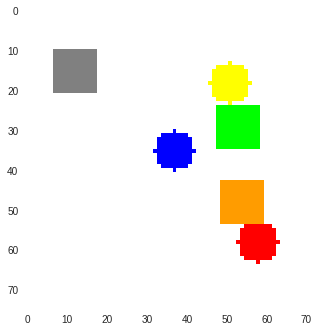

In [53]:
import matplotlib.pyplot as plt
def tensor_data(data, i):
    img = torch.from_numpy(np.asarray(data[0][bs*i:bs*(i+1)]))
    question = torch.from_numpy(np.asarray(data[1][bs*i:bs*(i+1)]))
    answer = torch.from_numpy(np.asarray(data[2][bs*i:bs*(i+1)]))
    input_img.data.resize_(img.size()).copy_(img)
    input_qst.data.resize_(question.size()).copy_(question)
    label.data.resize_(answer.size()).copy_(answer)
    
def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)
  
epoch=0
bs=64
input_img = torch.FloatTensor(bs, 3, 75, 75)
input_qst = torch.FloatTensor(bs, 11)
label = torch.LongTensor(bs)

model.cuda()
input_img = input_img.cuda()
input_qst = input_qst.cuda()
label = label.cuda()

accuracy_rels = []
idx=4#index of img,question,answer
rel_test2 = cvt_data_axis(rel_test)
batch_idx=1
# for batch_idx in range(len(rel_test2[0]) // bs):
tensor_data(rel_test2, batch_idx);
accuracy_rels.append(model.test_(input_img, input_qst, label)[0]);
img2 = np.swapaxes(input_img[idx].cpu().detach().numpy(),0,2)
plt.imshow(np.dstack((img2[:,:,2],img2[:,:,1],img2[:,:,0])));
plt.grid(False)
question=input_qst[idx]
query = ''
query += colors[question.tolist()[0:6].index(1)]+': '
if question[6] == 1:
    if question[8] == 1:
        query += 'shape?'
    if question[9] == 1:
        query += 'left?'
    if question[10] == 1:
        query += 'up?'
if question[7] == 1:
    if question[8] == 1:
        query += 'closest shape?'
    if question[9] == 1:
        query += 'furthest shape?'
    if question[10] == 1:
        query += 'count?'
print(query)    
print('Predicted answer',answer_sheet[accuracy_rels[0][idx]])
print('Desired answer',answer_sheet[label[idx]])

#     break
